In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time
np.random.seed(121)

In [2]:
def logpdfTarget (x, covariance_inverse=None):
    if (covariance_inverse is None):
        lnp = -(1/2) * (x.T).dot(x)
    else:
        lnp = -(1/2) * (x.T).dot(covariance_inverse).dot(x)
    return(lnp)

In [3]:
d = 2
cov = np.array([1,0.9,0.9,1]).reshape(2,2)
cov_inv = np.linalg.inv(cov)
Sigma_neg = fractional_matrix_power(cov,-0.5)
Sigma_pos = fractional_matrix_power(cov,0.5)

In [4]:
begin_total = time.time()
nround = int(10e5)
burnin = int(10e3)
size = len(range(-burnin,nround))
x = np.random.random(d) - 0.5
y = np.zeros(nround*d).reshape(nround,d)
mu_star = 0.1
target_result = {}

random_1DUniform = (np.random.random(size = size*d)-0.5) * np.sqrt(12)
random_1DNormal = np.random.normal(size = size*d)
random_Normal2D = np.random.multivariate_normal(np.zeros(d),np.eye(d),size = size)
random_Square2D = np.random.uniform(-np.sqrt(3), np.sqrt(3), size = (size,2))
r = np.random.uniform(size = size)
theta = np.random.uniform(low=0.0, high=2*np.pi, size = size)
random_Disc2D = np.array([[2*np.sqrt(r[i])*np.cos(theta[i]), 2*np.sqrt(r[i])*np.sin(theta[i])] for i in range(size)])

targetset = ['N0I','N0Sigma']
kernelset_N0I = ['Gaussian2D','Square2D','Disc2D','Two1DUniform','Two1DGaussian']
kernelset_N0Sigma = ['Gaussian2D','Square2D','Disc2D','Two1DUniform','Two1DGaussian',
                    'TransGaussian2D','Two1DTransfUniform','Two1DTransfGaussian','Two1DTransfMirrorU']

sigmaset = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5, 1.7,
    1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
    3.0, 3.2, 3.5, 4, 4.5, 5, 6]

for target in targetset:
    kernelset = kernelset_N0I if (target == 'N0I') else kernelset_N0Sigma
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}
    for kernel in kernelset:
        cov = None if ((target == 'N0I') | ('Trans' in kernel)) else cov_inv
        Eff = []; Pjump = []; Exx2=[]
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = np.zeros(d)
            if ('1D' in kernel):
                for j in range(-burnin,nround):
                    if (j==0):
                        accept = np.zeros(d);
                    for i in range(d):
                        initial = x.copy()
                        pi_old = logpdfTarget(initial,cov)
                        if ('Uniform' in kernel):
                            initial[i] += random_1DUniform[(j+burnin)*d+i] * sigma    #Uniform
                        elif ('Gaussian' in kernel):
                            initial[i] += random_1DNormal[(j+burnin)*d+i] * sigma     #Gaussian
                        elif ('Mirror' in kernel):
                            NewCenter = 2*mu_star - initial[i]
                            initial[i] = NewCenter + random_1DUniform[(j+burnin)*d+i] * sigma    #Mirror Uniform
                        else:
                            sys.exit('No such kernel exists')
                        pi_new = logpdfTarget(initial,cov)
                        pi_dif = pi_new - pi_old
                        if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                            exx2 = exx2 + (np.square(initial[i]-x[i]) if i == 0 else 0)
                            x = initial
                            accept[i] += 1     
                    if (j>=0):
                        y[j,:] = np.dot(Sigma_pos,x) if ('Trans' in kernel) else x
                eff = Eff_IntegratedCorrelationTime(y[:,0])
                Eff.append(eff)
                Pjump.append(accept[0]/nround)
                Exx2.append(exx2/nround)
                print ('Target:',target,'Kernel:',kernel,' sigma:',sigma,' eff:',round(eff,4), ' Pjump:', round(accept[0]/nround,4), ' Exx2:', round(exx2/nround,4), ' 用时: %f'% (time.time()-begin_loop))
            elif('2D' in kernel):
                for j in range(-burnin,nround):
                    if (j==0):
                        accept = 0;
                    if 'Gaussian' in kernel:
                        xnew = x + random_Normal2D[j+burnin] * sigma
                    elif kernel == 'Square2D':
                        xnew = x + random_Square2D[j+burnin,:] *sigma
                    elif kernel == 'Disc2D':
                        xnew = x + random_Disc2D[j+burnin,:] *sigma
                    pi_dif = logpdfTarget(xnew,cov) - logpdfTarget(x,cov)
                    if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                        exx2 += np.square(xnew[0]-x[0])
                        x = xnew
                        accept += 1
                    if (j>=0):
                        y[j,:] = np.dot(Sigma_pos,x) if 'Trans' in kernel else x 
                eff = (Eff_IntegratedCorrelationTime(y[:,0]))
                Eff.append(eff)
                Pjump.append(accept/nround)
                Exx2.append(exx2/nround)
                print ('Target:',target,' Kernel:',kernel,' sigma:',sigma,' eff:',round(eff,4), ' Pjump:', round(accept/nround,4), ' Exx2:', round(exx2/nround,4), ' 用时: %f'% (time.time()-begin_loop))
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel]
print('总共用时: %f'% (time.time()-begin_total))

Target: N0I  Kernel: Gaussian2D  sigma: 0.1  eff: 0.0023  Pjump: 0.9495  Exx2: 0.0093  用时: 11.140665
Target: N0I  Kernel: Gaussian2D  sigma: 0.3  eff: 0.0176  Pjump: 0.852  Exx2: 0.0708  用时: 9.387745
Target: N0I  Kernel: Gaussian2D  sigma: 0.5  eff: 0.0411  Pjump: 0.7575  Exx2: 0.1624  用时: 8.622952
Target: N0I  Kernel: Gaussian2D  sigma: 0.7  eff: 0.0669  Pjump: 0.6695  Exx2: 0.2583  用时: 8.176219
Target: N0I  Kernel: Gaussian2D  sigma: 0.9  eff: 0.0914  Pjump: 0.5905  Exx2: 0.3435  用时: 9.173095
Target: N0I  Kernel: Gaussian2D  sigma: 1.0  eff: 0.1006  Pjump: 0.553  Exx2: 0.3771  用时: 8.646035
Target: N0I  Kernel: Gaussian2D  sigma: 1.1  eff: 0.1084  Pjump: 0.5179  Exx2: 0.4051  用时: 8.466072
Target: N0I  Kernel: Gaussian2D  sigma: 1.3  eff: 0.1215  Pjump: 0.4549  Exx2: 0.4503  用时: 8.721214
Target: N0I  Kernel: Gaussian2D  sigma: 1.5  eff: 0.1327  Pjump: 0.4003  Exx2: 0.4735  用时: 8.561307
Target: N0I  Kernel: Gaussian2D  sigma: 1.7  eff: 0.136  Pjump: 0.3528  Exx2: 0.4809  用时: 8.491600
Ta

Target: N0I Kernel: Two1DUniform  sigma: 0.7  eff: 0.0816  Pjump: 0.7653  Exx2: 0.3228  用时: 14.696259
Target: N0I Kernel: Two1DUniform  sigma: 0.9  eff: 0.1182  Pjump: 0.7033  Exx2: 0.4601  用时: 14.462678
Target: N0I Kernel: Two1DUniform  sigma: 1.0  eff: 0.1367  Pjump: 0.674  Exx2: 0.526  用时: 15.003488
Target: N0I Kernel: Two1DUniform  sigma: 1.1  eff: 0.157  Pjump: 0.6457  Exx2: 0.5882  用时: 15.215384
Target: N0I Kernel: Two1DUniform  sigma: 1.3  eff: 0.1953  Pjump: 0.5922  Exx2: 0.6958  用时: 16.051377
Target: N0I Kernel: Two1DUniform  sigma: 1.5  eff: 0.2243  Pjump: 0.5431  Exx2: 0.7811  用时: 14.844255
Target: N0I Kernel: Two1DUniform  sigma: 1.7  eff: 0.2532  Pjump: 0.4992  Exx2: 0.8417  用时: 14.871794
Target: N0I Kernel: Two1DUniform  sigma: 1.8  eff: 0.2612  Pjump: 0.4785  Exx2: 0.8618  用时: 14.748613
Target: N0I Kernel: Two1DUniform  sigma: 1.9  eff: 0.2682  Pjump: 0.4585  Exx2: 0.8733  用时: 14.130246
Target: N0I Kernel: Two1DUniform  sigma: 2.0  eff: 0.2723  Pjump: 0.4404  Exx2: 0.883

Target: N0Sigma  Kernel: Square2D  sigma: 0.5  eff: 0.0201  Pjump: 0.5234  Exx2: 0.1123  用时: 9.448371
Target: N0Sigma  Kernel: Square2D  sigma: 0.7  eff: 0.0334  Pjump: 0.4032  Exx2: 0.1591  用时: 8.993157
Target: N0Sigma  Kernel: Square2D  sigma: 0.9  eff: 0.0443  Pjump: 0.3159  Exx2: 0.1948  用时: 8.722783
Target: N0Sigma  Kernel: Square2D  sigma: 1.0  eff: 0.0465  Pjump: 0.2811  Exx2: 0.2086  用时: 8.721790
Target: N0Sigma  Kernel: Square2D  sigma: 1.1  eff: 0.0531  Pjump: 0.2522  Exx2: 0.2197  用时: 8.560994
Target: N0Sigma  Kernel: Square2D  sigma: 1.3  eff: 0.0548  Pjump: 0.2037  Exx2: 0.2346  用时: 8.467714
Target: N0Sigma  Kernel: Square2D  sigma: 1.5  eff: 0.0583  Pjump: 0.1671  Exx2: 0.2404  用时: 8.424726
Target: N0Sigma  Kernel: Square2D  sigma: 1.7  eff: 0.0597  Pjump: 0.1383  Exx2: 0.2368  用时: 8.320631
Target: N0Sigma  Kernel: Square2D  sigma: 1.8  eff: 0.0568  Pjump: 0.1257  Exx2: 0.2313  用时: 8.390283
Target: N0Sigma  Kernel: Square2D  sigma: 1.9  eff: 0.0589  Pjump: 0.1159  Exx2: 0

Target: N0Sigma Kernel: Two1DGaussian  sigma: 0.5  eff: 0.0151  Pjump: 0.6681  Exx2: 0.0992  用时: 17.770998
Target: N0Sigma Kernel: Two1DGaussian  sigma: 0.7  eff: 0.021  Pjump: 0.57  Exx2: 0.1281  用时: 17.793500
Target: N0Sigma Kernel: Two1DGaussian  sigma: 0.9  eff: 0.023  Pjump: 0.4907  Exx2: 0.1404  用时: 17.195883
Target: N0Sigma Kernel: Two1DGaussian  sigma: 1.0  eff: 0.0236  Pjump: 0.4563  Exx2: 0.1418  用时: 17.482013
Target: N0Sigma Kernel: Two1DGaussian  sigma: 1.1  eff: 0.0232  Pjump: 0.4265  Exx2: 0.1424  用时: 17.036195
Target: N0Sigma Kernel: Two1DGaussian  sigma: 1.3  eff: 0.0232  Pjump: 0.3765  Exx2: 0.1396  用时: 16.456952
Target: N0Sigma Kernel: Two1DGaussian  sigma: 1.5  eff: 0.0218  Pjump: 0.3355  Exx2: 0.1331  用时: 16.534842
Target: N0Sigma Kernel: Two1DGaussian  sigma: 1.7  eff: 0.0207  Pjump: 0.3018  Exx2: 0.1262  用时: 16.136378
Target: N0Sigma Kernel: Two1DGaussian  sigma: 1.8  eff: 0.0197  Pjump: 0.2871  Exx2: 0.122  用时: 15.399319
Target: N0Sigma Kernel: Two1DGaussian  sig

Target: N0Sigma Kernel: Two1DTransfUniform  sigma: 4.5  eff: 0.1477  Pjump: 0.205  Exx2: 0.5579  用时: 14.071373
Target: N0Sigma Kernel: Two1DTransfUniform  sigma: 5  eff: 0.13  Pjump: 0.1843  Exx2: 0.4979  用时: 14.524565
Target: N0Sigma Kernel: Two1DTransfUniform  sigma: 6  eff: 0.106  Pjump: 0.1532  Exx2: 0.412  用时: 14.480200
Target: N0Sigma Kernel: Two1DTransfGaussian  sigma: 0.1  eff: 0.0021  Pjump: 0.9688  Exx2: 0.0095  用时: 20.846822
Target: N0Sigma Kernel: Two1DTransfGaussian  sigma: 0.3  eff: 0.0178  Pjump: 0.9058  Exx2: 0.0739  用时: 17.639997
Target: N0Sigma Kernel: Two1DTransfGaussian  sigma: 0.5  eff: 0.0438  Pjump: 0.8442  Exx2: 0.1755  用时: 17.199783
Target: N0Sigma Kernel: Two1DTransfGaussian  sigma: 0.7  eff: 0.075  Pjump: 0.7857  Exx2: 0.291  用时: 16.672055
Target: N0Sigma Kernel: Two1DTransfGaussian  sigma: 0.9  eff: 0.105  Pjump: 0.7308  Exx2: 0.4025  用时: 16.413941
Target: N0Sigma Kernel: Two1DTransfGaussian  sigma: 1.0  eff: 0.1206  Pjump: 0.7051  Exx2: 0.4549  用时: 16.17941

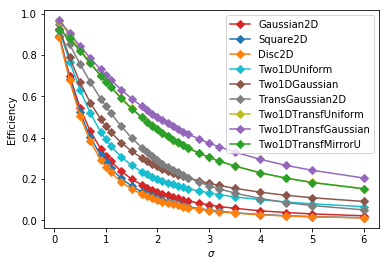

In [24]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
Pjump_kernel = target_result['N0Sigma'][1]
kernelset = list(target_result['N0Sigma'][0].keys())
[plt.plot(sigmaset,Pjump_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(9)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Pjump_N0Sigma9.eps', format='eps', dpi=1000)
plt.show()

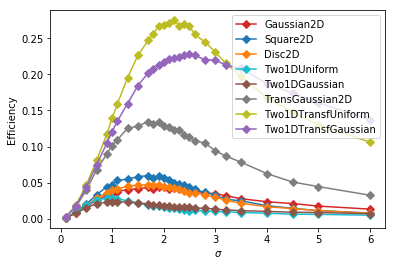

In [23]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
eff_kernel = target_result['N0Sigma'][0]
kernelset = list(target_result['N0Sigma'][0].keys())
[plt.plot(sigmaset,eff_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(8)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Eff_N0Sigma8.eps', format='eps', dpi=1000)
plt.show()

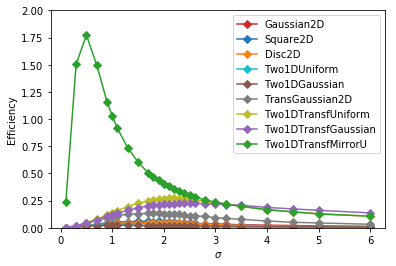

In [20]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
eff_kernel = target_result['N0Sigma'][0]
kernelset = list(target_result['N0Sigma'][0].keys())
[plt.plot(sigmaset,eff_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(9)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.ylim(0,2)
plt.savefig('Eff_N0Sigma9.eps', format='eps', dpi=1000)
plt.show()

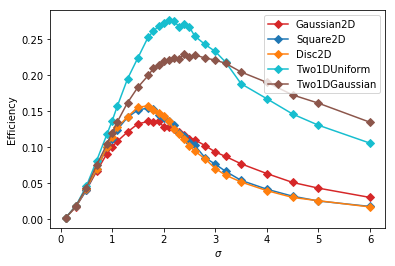

In [15]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
eff_kernel = target_result['N0I'][0]
kernelset = list(target_result['N0I'][0].keys())
[plt.plot(sigmaset,eff_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(5)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Eff_N0I.eps', format='eps', dpi=1000)
plt.show()

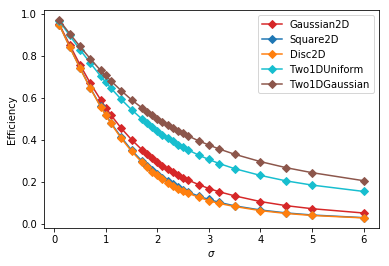

In [13]:
color = ['tab:red','tab:blue','tab:orange','tab:cyan','tab:brown','tab:grey','tab:olive','tab:purple','tab:green']
pjump_kernel = target_result['N0I'][1]
kernelset = list(target_result['N0I'][0].keys())
[plt.plot(sigmaset,pjump_kernel[kernelset[i]],marker='D',color=color[i],label=kernelset[i]) for i in range(5)]
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.ylabel('Efficiency', fontsize=10)
plt.savefig('Pjump_N0I', format='eps', dpi=1000)
plt.show()